# 数据准备阶段

已经生成好图片的可以从数据准备3开始执行

### 数据准备1

该过程为 将原图转换成阶段0（抠图完成）的图

### 数据准备2

该过程为 将阶段1（抠图完成）的图转换成阶段2（随机裁剪和扩充n倍的图）的图

In [2]:
# 阶段1的图地址
train_dir = 'pig_pic_src/train/'
valid_dir = 'pig_pic_src/valid/'

# 阶段2的图地址
processed_train_dir = 'pig_pic_src_processed/train/'
processed_valid_dir = 'pig_pic_src_processed/valid/'

# 封装好的预处理函数
from jpg_data_preprocess import *

# 执行阶段2预处理
preprocess_all_pics(valid_dir, processed_valid_dir, train = False)
preprocess_all_pics(train_dir, processed_train_dir, data_plus = 10, train = True)

pig_pic_src/valid/01.pig -> pig_pic_src_processed/valid/01.pig#  start process
3 images processed
pig_pic_src/valid/02.pig -> pig_pic_src_processed/valid/02.pig#  start process
5 images processed
pig_pic_src/valid/03.pig -> pig_pic_src_processed/valid/03.pig#  start process
4 images processed
pig_pic_src/valid/04.pig -> pig_pic_src_processed/valid/04.pig#  start process
4 images processed
pig_pic_src/valid/05.pig -> pig_pic_src_processed/valid/05.pig#  start process
3 images processed
pig_pic_src/valid/06.pig -> pig_pic_src_processed/valid/06.pig#  start process
5 images processed
pig_pic_src/valid/07.pig -> pig_pic_src_processed/valid/07.pig#  start process
4 images processed
pig_pic_src/valid/08.pig -> pig_pic_src_processed/valid/08.pig#  start process
5 images processed
pig_pic_src/valid/09.pig -> pig_pic_src_processed/valid/09.pig#  start process
5 images processed
pig_pic_src/valid/10.pig -> pig_pic_src_processed/valid/10.pig#  start process
4 images processed
pig_pic_src/valid/11

30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
154 images processed
pig_pic_src/train/15.pig -> pig_pic_src_processed/train/15.pig#  start process
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
167 images processed
pig_pic_src/train/16.pig -> pig_pic_src_processed/train/16.pig#  start process
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 im

### 数据准备3

该过程为 将阶段2（随机裁剪和扩充完成）的图 交给keras图像生成器（包括增强，随机化，归一化，迭代等）变成模型可用状态

In [1]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from utils import *

Using TensorFlow backend.


In [2]:
# 数据准备
IM_WIDTH, IM_HEIGHT = 299, 299 #InceptionV3指定的图片尺寸
FC_SIZE = 1024                 # 全连接层的节点个数
NB_IV3_LAYERS_TO_FREEZE = 172  # 冻结层的数量

# 数据来源路径
train_dir = "E:/PROJECT/Competition/TogithubTransfer/pig_pic_src_processed/train"  # 训练集数据
val_dir = "E:/PROJECT/Competition/TogithubTransfer/pig_pic_src_processed/valid"    # 验证集数据

#train_dir = "E:/PROJECT/Competition/TogithubTransfer/pig-test/train"  # 训练集数据
#val_dir = "E:/PROJECT/Competition/TogithubTransfer/pig-test/valid"    # 验证集数据


nb_classes= 3
nb_epoch = 1
batch_size = 48

nb_train_samples = get_nb_files(train_dir)       # 训练样本个数
nb_classes = len(glob.glob(train_dir + "/*"))    # 分类数
nb_val_samples = get_nb_files(val_dir)           # 验证集样本个数
nb_epoch = int(nb_epoch)                         # epoch数量
batch_size = int(batch_size)                     # 
                                                
#　图片生成器
train_datagen =  ImageDataGenerator(featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    zca_epsilon=0,
                                    rotation_range=0.0,
                                    width_shift_range=0.,
                                    height_shift_range=0.,
                                    shear_range=0.,
                                    zoom_range=0.,
                                    channel_shift_range=0.,
                                    fill_mode='nearest',
                                    cval=0.,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    rescale=1./255,
                                    preprocessing_function=None)
test_datagen = ImageDataGenerator(featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    zca_epsilon=0,
                                    rotation_range=0.,
                                    width_shift_range=0.,
                                    height_shift_range=0.,
                                    shear_range=0.,
                                    zoom_range=0.,
                                    channel_shift_range=0.,
                                    fill_mode='nearest',
                                    cval=0.,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    rescale=1./255,
                                    preprocessing_function=None)

# 训练数据与测试数据
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IM_WIDTH, IM_HEIGHT),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(IM_WIDTH, IM_HEIGHT),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 49830 images belonging to 30 classes.
Found 119 images belonging to 30 classes.


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
(48, 299, 299, 3)


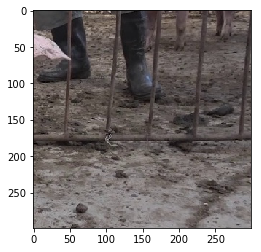

In [3]:
# 查看生成器生成数据
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage import imread

for train_x, train_y in train_generator:
    print(train_y[0])
    print(train_x.shape)
    #print(train_x[0][0])
    plt.imshow(train_x[0])
    break

# 模型构造阶段

In [4]:
# 添加新层
def add_new_last_layer(base_model, nb_classes):
    """
    添加最后的层
    输入
    base_model和分类数量
    输出
    新的keras的model
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) #new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 冻上base_model所有层，这样就可以正确获得bottleneck特征
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
        #print(layer.name)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    
# 定义网络框架
print("1")
base_model = InceptionV3(weights='imagenet', include_top=False) # 预先要下载no_top模型
print("2")
base_model.load_weights("inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")
print("3")
model = add_new_last_layer(base_model, nb_classes)              # 从基本no_top模型上添加新层
print("4")
setup_to_transfer_learn(model, base_model)                      # 冻结base_model所有层

model.summary()

1
2
3
4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
co

# 模型训练阶段

In [46]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf   
checkpointer = ModelCheckpoint(filepath='xceptionv3.weights.best.hdf5', verbose=1, #Xcp
                               save_best_only=True)

print(nb_train_samples // batch_size)
print(nb_val_samples // batch_size)
# 训练

#tb = TensorBoard(log_dir=log_dir, histogram_freq=0)

history_tl = model.fit_generator(train_generator,
                                epochs = nb_epoch,
                                steps_per_epoch = nb_train_samples // batch_size,
                                validation_data = validation_generator,
                                validation_steps = nb_val_samples // batch_size,
                                class_weight='auto',
                                callbacks=[checkpointer],
                                verbose = 1,
                                shuffle = False)

1038
2
Epoch 1/1
1037/1038 [============================>.] - ETA: 1s - loss: 1.6403 - acc: 0.5331

ResourceExhaustedError: OOM when allocating tensor with shape[48,64,147,147]
	 [[Node: conv2d_379/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_378/Relu, conv2d_379/kernel)]]
	 [[Node: metrics_4/acc/Mean/_13059 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_5444_metrics_4/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_379/convolution', defined at:
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-d99cf042abf7>", line 29, in <module>
    base_model = InceptionV3(weights='imagenet', include_top=False) # 预先要下载no_top模型
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\keras\applications\inception_v3.py", line 173, in InceptionV3
    x = conv2d_bn(x, 64, 3, 3)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\keras\applications\inception_v3.py", line 79, in conv2d_bn
    name=conv_name)(x)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\keras\backend\tensorflow_backend.py", line 3189, in conv2d
    data_format=tf_data_format)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 672, in convolution
    op=op)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 664, in op
    name=name)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\framework\ops.py", line 2628, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "d:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[48,64,147,147]
	 [[Node: conv2d_379/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_378/Relu, conv2d_379/kernel)]]
	 [[Node: metrics_4/acc/Mean/_13059 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_5444_metrics_4/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [48]:
accuracy_curve(history_tl)

NameError: name 'history_tl' is not defined

# 测试验证阶段

In [5]:
model.load_weights(filepath='xceptionv3.weights.best.hdf5', by_name=False)

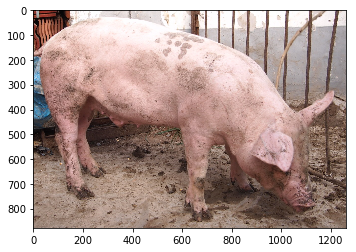

In [6]:
# 挑选一张图片调试

# 显示
test_img_path = 'test_A/201.JPG'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [7]:
# 查看模型预测结果
img = load_image(test_img_path)
img = img.reshape((1, 299, 299, 3))

preds = model.predict(img)
print(preds)

[[  3.11347714e-04   9.35650989e-03   2.59124179e-04   8.44963070e-04
    2.10086655e-04   6.16863021e-04   1.18877622e-03   1.55289581e-05
    1.34943150e-07   9.82921506e-07   8.79521976e-05   1.28559172e-04
    1.65585370e-04   1.11923546e-05   8.45908380e-06   7.37242499e-06
    4.06497056e-05   7.31996533e-06   1.83798969e-04   8.37767683e-03
    7.62495387e-04   4.71442123e-04   8.74271214e-01   5.88144641e-03
    1.56475890e-05   2.36897301e-02   2.55386643e-02   2.19830297e-04
    4.67456914e-02   5.80961932e-04]]


# CSV输出阶段

In [8]:
# A榜数据地址
testA_dir = 'test_A/'
# 运行模型预测
test_preds = run_model(testA_dir, model)
# csv输出地址
output_csv_path = 'output.csv'
# 输出 csv
make_csv_file(output_csv_path, testA_dir, test_preds)

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed
2100 images processed
2200 images processed
2300 images processed
2400 images processed
2500 images processed
2600 images processed
2700 images processed
2800 images processed
2900 images processed
3000 images processed
